## Import libraries and python files

In [37]:
#import useful libraries 
import pandas as pd
import json
import sys
import requests
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
%matplotlib inline
import matplotlib.pyplot as plt

from data_loader import *
%load_ext autoreload
%autoreload 2


##link to the datasets
##https://www.cs.cmu.edu/~ark/personas/
##https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=movies_metadata.csv
##https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset
##https://www.kaggle.com/datasets/unanimad/the-oscar-award/data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the different datasets

In [4]:
##load datasets from CMU dataset
df_character = load_character().copy()
df_movie = load_movie().copy()
df_name_cluster = load_name_cluster().copy()
df_summary = load_plot_summary().copy()
df_tropes_cluster = load_tropes_cluster().copy()

In [5]:
df_movie.head()

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>


In [6]:
df_movie.shape

(81741, 12)

In [7]:
# Replace 'id-translation.wikidata.json' with the path to your JSON file
file_path = 'id-translation.wikidata.json'

# Load the JSON file into a DataFrame
df_id_translation = pd.read_json(file_path, orient='records', lines=True)

# Display the loaded DataFrame
display(df_id_translation)

,tconst,Freebase ID
0,nm0010930,/m/0282x
1,nm0124133,/m/09b6zr
2,nm0684496,/m/014d3
3,nm0061667,/m/01rgr
4,tt1675434,/m/0hgqwpj
...,...,...
990440,tt20913312,None
990441,tt29623578,None
990442,nm1456284,None
990443,tt27348595,None


In [8]:
df_id_translation = df_id_translation.dropna(subset=['Freebase ID'])
#df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)
print(df_id_translation.shape)

(397518, 2)


In [9]:
df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)
print(df_id_translation.shape)

(396337, 2)


In [10]:
df_movie = pd.merge(df_movie, df_id_translation, on='Freebase ID', how='left')
display(df_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day,tconst
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,tt0228333
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,tt0245916
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,tt0094806
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,tt0094320
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,tt0083949
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,tt1816585
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,tt1606259
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,tt0362411
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,tt0113726


In [11]:
#compute percentage of missing values for df_mvoei
percentage_missing_values_year = (df_movie['Year'].isna().sum()/len(df_movie['Year']))*100
print(f"The percentage of missing values 'Year' release date is {format(percentage_missing_values_year, '.3f')}%.")

percentage_missing_values_month = (df_movie['Month'].isna().sum()/len(df_movie['Month']))*100
print(f"The percentage of missing values 'Month' release date (and therefore 'Day') is {format(percentage_missing_values_month, '.3f')}%.")

percentage_missing_values_revenues = (df_movie['Box office'].isna().sum()/len(df_movie['Box office']))*100
print(f"The percentage of missing values 'Box office' is {format(percentage_missing_values_revenues, '.3f')}%.")

percentage_missing_values_runtime = (df_movie['Runtime'].isna().sum()/len(df_movie['Runtime']))*100
print(f"The percentage of missing values 'Runtime' is {format(percentage_missing_values_runtime, '.3f')}%.")

percentage_missing_values_tconst = (df_movie['tconst'].isna().sum()/len(df_movie['tconst']))*100
print(f"The percentage of missing values 'tconst' is {format(percentage_missing_values_tconst, '.3f')}%.")


The percentage of missing values 'Year' release date is 8.444%.
The percentage of missing values 'Month' release date (and therefore 'Day') is 51.832%.
The percentage of missing values 'Box office' is 89.722%.
The percentage of missing values 'Runtime' is 25.018%.
The percentage of missing values 'tconst' is 9.769%.


In [12]:
##As we can see, a lot of 'Box office' and 'Month' data is missing

## Finding trend by genre

First of all, let's look at the data from the initial dataset

In [15]:
print(f"Number of null values in genre: {df_movie['genres (Freebase ID:name tuples)'].isna().sum()}")

df_empty_genre_movie = df_movie[df_movie['genres (Freebase ID:name tuples)'] == '{}']
print(f"Number of "+repr({})+f" genres: {df_empty_genre_movie['genres (Freebase ID:name tuples)'].size}")

precentage_missing_genre = (df_empty_genre_movie['genres (Freebase ID:name tuples)'].size/df_movie['genres (Freebase ID:name tuples)'].size)*100
print(f"The percentage of of missing genre movie: {format(precentage_missing_genre, '.3f')}%.")
      
df_movie['genres (Freebase ID:name tuples)'].head

Number of null values in genre: 0
Number of {} genres: 2294
The percentage of of missing genre movie: 2.806%.


<bound method NDFrame.head of 0        {"/m/01jfsb": "Thriller", "/m/06n90": "Science...
1        {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...
2        {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...
3        {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...
4                                  {"/m/07s9rl0": "Drama"}
                               ...                        
81736                              {"/m/07s9rl0": "Drama"}
81737    {"/m/03bxz7": "Biographical film", "/m/07s9rl0...
81738         {"/m/06nbt": "Satire", "/m/01z4y": "Comedy"}
81739    {"/m/06n90": "Science Fiction", "/m/0gw5n2f": ...
81740    {"/m/01jfsb": "Thriller", "/m/03npn": "Horror"...
Name: genres (Freebase ID:name tuples), Length: 81741, dtype: object>

Here, we can see that the genre data is stocked as a JSON, there is no null value but some empty JSON that we will need to remove. Regardless, for now, of the other missing value in other columns, only a small percentage has an empty genre. 
Thus, we should be able to have enough data to analyse, but we need to transform the JSON to something usable.

We will first transform the JSON to a list and, as we analyse the release date of these movie, we need to remove the null value of the relase date too.

In [18]:
def parse_genre_json(genre_json):
    try:
        genre_dict = json.loads(genre_json)
        genre_list = list(genre_dict.values())
        return genre_list
    except (json.JSONDecodeError, AttributeError):
        return []

df_genre_movie = df_movie[df_movie['genres (Freebase ID:name tuples)'] != '{}'].copy(deep=True)
df_genre_movie['genres'] = df_genre_movie['genres (Freebase ID:name tuples)'].apply(parse_genre_json)
df_genre_movie.drop(columns=['genres (Freebase ID:name tuples)'], inplace=True)
df_genre_movie.dropna(subset=['Day','Month', 'Year'],inplace=True)

display(df_genre_movie['genres'])
print(df_genre_movie['genres'].size)

0        [Thriller, Science Fiction, Horror, Adventure,...
1         [Mystery, Biographical film, Drama, Crime Drama]
5        [Short Film, Silent film, Indie, Black-and-whi...
7                       [Musical, Comedy, Black-and-white]
12       [Romantic comedy, Ensemble Film, Comedy-drama,...
                               ...                        
81735               [Sports, Crime Fiction, Action, Drama]
81736                                              [Drama]
81737              [Biographical film, Drama, Documentary]
81738                                     [Satire, Comedy]
81739    [Science Fiction, Japanese Movies, Adventure, ...
Name: genres, Length: 38832, dtype: object

38832


Now we have something to work on. Let's group the movie by their genre.

In [30]:
df_full_genres = df_genre_movie.explode('genres')
df_group_genres= df_full_genres.groupby('genres')
genre_counts = df_group_genres.size().reset_index(name='movie_count')
print("Number of genres: " + str(genre_counts['genres'].size))
genre_counts.sort_values(by= 'movie_count', ascending= False).head(10)

Number of genres: 348


,genres,movie_count
111,Drama,17592
72,Comedy,9456
278,Romance Film,5849
42,Black-and-white,5635
329,Thriller,4984
2,Action,4808
294,Short Film,4188
191,Indie,4057
95,Crime Fiction,3826
295,Silent film,3578


In [35]:
genre_counts_less_ten = genre_counts[genre_counts['movie_count']<10]
print("Number of genre with less than 10 movie: "+ str(genre_counts_less_ten['genres'].size))

Number of genre with less than 10 movie: 98


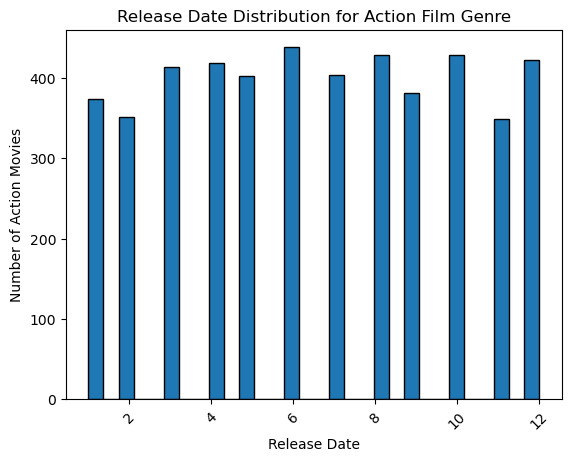

In [40]:
# We should check: the genre by month, and by year maybe ?
genre = 'Action'
genre_movie = df_group_genres.get_group(genre)

plt.hist(genre_movie['Month'], bins=30, edgecolor='k')
plt.title('Release Date Distribution for '+genre +' Film Genre')
plt.xlabel('Release Date')
plt.ylabel('Number of '+genre +' Movies')
plt.xticks(rotation=45)
plt.show()